# Skin Lesion Classification — Transfer Learning
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```

**Model:** EfficientNet-B0

In [9]:
# Environment & imports
# If running in a fresh environment, you may need to install packages:
# !pip install torch torchvision matplotlib scikit-learn tqdm timm -q
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Note: you may need to restart the kernel to use updated packages.
Device: cpu


In [10]:
# Paths (change these to your dataset locations)
train_dir = r"D:\archive\train"
val_dir   = r"D:\archive\val"

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (14): ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 29322  Val size: 3660


In [11]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 2658, 2099, 900, 792, 191, 1932, 1368, 660, 10300, 3617, 3408, 502, 202]
Class weights: tensor([ 42.3117,  11.0316,  13.9695,  32.5800,  37.0227, 153.5183,  15.1770,
         21.4342,  44.4273,   2.8468,   8.1067,   8.6039,  58.4104, 145.1584])


In [ ]:
# EfficientNet-B0 (torchvision if available)
try:
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # If torchvision doesn't have efficientnet in your environment, use timm (uncomment install if needed)
    # !pip install timm -q
    import timm
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model = model.to(device)


In [14]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 30  # change as needed


In [15]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [16]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="EfficientNet-B0")


Epoch 1/30


100%|██████████| 917/917 [32:45<00:00,  2.14s/it]


train Loss: 1.4036 Acc: 0.5312 F1: 0.4349


100%|██████████| 115/115 [01:10<00:00,  1.63it/s]


val Loss: 0.9817 Acc: 0.6508 F1: 0.5956
------------------------------
Epoch 2/30


100%|██████████| 917/917 [27:39<00:00,  1.81s/it]


train Loss: 0.9167 Acc: 0.6398 F1: 0.5690


100%|██████████| 115/115 [01:08<00:00,  1.67it/s]


val Loss: 0.8031 Acc: 0.6973 F1: 0.6588
------------------------------
Epoch 3/30


100%|██████████| 917/917 [27:39<00:00,  1.81s/it]


train Loss: 0.7819 Acc: 0.6792 F1: 0.6187


100%|██████████| 115/115 [01:08<00:00,  1.68it/s]


val Loss: 0.6431 Acc: 0.7617 F1: 0.7157
------------------------------
Epoch 4/30


100%|██████████| 917/917 [27:29<00:00,  1.80s/it]


train Loss: 0.7001 Acc: 0.7044 F1: 0.6517


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


val Loss: 0.6095 Acc: 0.7798 F1: 0.7418
------------------------------
Epoch 5/30


100%|██████████| 917/917 [27:42<00:00,  1.81s/it]


train Loss: 0.6375 Acc: 0.7195 F1: 0.6715


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


val Loss: 0.6468 Acc: 0.7607 F1: 0.7191
------------------------------
Epoch 6/30


100%|██████████| 917/917 [27:53<00:00,  1.82s/it]


train Loss: 0.5984 Acc: 0.7351 F1: 0.6919


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


val Loss: 0.5337 Acc: 0.8057 F1: 0.7839
------------------------------
Epoch 7/30


100%|██████████| 917/917 [28:07<00:00,  1.84s/it]


train Loss: 0.5584 Acc: 0.7492 F1: 0.7088


100%|██████████| 115/115 [01:10<00:00,  1.64it/s]


val Loss: 0.4989 Acc: 0.8216 F1: 0.7866
------------------------------
Epoch 8/30


100%|██████████| 917/917 [28:15<00:00,  1.85s/it]


train Loss: 0.5330 Acc: 0.7563 F1: 0.7205


100%|██████████| 115/115 [01:11<00:00,  1.62it/s]


val Loss: 0.4862 Acc: 0.8210 F1: 0.7849
------------------------------
Epoch 9/30


100%|██████████| 917/917 [28:16<00:00,  1.85s/it]


train Loss: 0.5051 Acc: 0.7686 F1: 0.7331


100%|██████████| 115/115 [01:12<00:00,  1.60it/s]


val Loss: 0.4800 Acc: 0.8279 F1: 0.8017
------------------------------
Epoch 10/30


100%|██████████| 917/917 [28:11<00:00,  1.84s/it]


train Loss: 0.4699 Acc: 0.7730 F1: 0.7421


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


val Loss: 0.4631 Acc: 0.8309 F1: 0.8073
------------------------------
Epoch 11/30


100%|██████████| 917/917 [28:21<00:00,  1.86s/it]


train Loss: 0.4499 Acc: 0.7844 F1: 0.7537


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


val Loss: 0.4790 Acc: 0.8240 F1: 0.8174
------------------------------
Epoch 12/30


100%|██████████| 917/917 [27:18<00:00,  1.79s/it]


train Loss: 0.4413 Acc: 0.7842 F1: 0.7538


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


val Loss: 0.4469 Acc: 0.8339 F1: 0.8423
------------------------------
Epoch 13/30


100%|██████████| 917/917 [28:10<00:00,  1.84s/it]


train Loss: 0.4274 Acc: 0.7966 F1: 0.7683


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


val Loss: 0.4423 Acc: 0.8374 F1: 0.8288
------------------------------
Epoch 14/30


100%|██████████| 917/917 [30:07<00:00,  1.97s/it]


train Loss: 0.3932 Acc: 0.8033 F1: 0.7788


100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


val Loss: 0.4362 Acc: 0.8440 F1: 0.8369
------------------------------
Epoch 15/30


100%|██████████| 917/917 [26:28<00:00,  1.73s/it]


train Loss: 0.3785 Acc: 0.8105 F1: 0.7932


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


val Loss: 0.4262 Acc: 0.8454 F1: 0.8561
------------------------------
Epoch 16/30


100%|██████████| 917/917 [36:44<00:00,  2.40s/it]


train Loss: 0.3834 Acc: 0.8113 F1: 0.7893


100%|██████████| 115/115 [01:56<00:00,  1.02s/it]


val Loss: 0.4511 Acc: 0.8325 F1: 0.8242
------------------------------
Epoch 17/30


100%|██████████| 917/917 [31:09<00:00,  2.04s/it]


train Loss: 0.3648 Acc: 0.8163 F1: 0.7936


100%|██████████| 115/115 [01:08<00:00,  1.68it/s]


val Loss: 0.4620 Acc: 0.8361 F1: 0.8206
------------------------------
Epoch 18/30


100%|██████████| 917/917 [27:43<00:00,  1.81s/it]


train Loss: 0.3493 Acc: 0.8187 F1: 0.8007


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


val Loss: 0.3937 Acc: 0.8609 F1: 0.8559
------------------------------
Epoch 19/30


100%|██████████| 917/917 [27:19<00:00,  1.79s/it]


train Loss: 0.3474 Acc: 0.8262 F1: 0.8075


100%|██████████| 115/115 [01:08<00:00,  1.67it/s]


val Loss: 0.4227 Acc: 0.8464 F1: 0.8398
------------------------------
Epoch 20/30


100%|██████████| 917/917 [27:46<00:00,  1.82s/it]


train Loss: 0.3317 Acc: 0.8271 F1: 0.8051


100%|██████████| 115/115 [01:05<00:00,  1.77it/s]


val Loss: 0.3882 Acc: 0.8634 F1: 0.8680
------------------------------
Epoch 21/30


100%|██████████| 917/917 [27:55<00:00,  1.83s/it]


train Loss: 0.3258 Acc: 0.8363 F1: 0.8212


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


val Loss: 0.4012 Acc: 0.8555 F1: 0.8584
------------------------------
Epoch 22/30


100%|██████████| 917/917 [26:54<00:00,  1.76s/it]


train Loss: 0.3198 Acc: 0.8338 F1: 0.8183


100%|██████████| 115/115 [01:19<00:00,  1.45it/s]


val Loss: 0.4523 Acc: 0.8478 F1: 0.8221
------------------------------
Epoch 23/30


100%|██████████| 917/917 [27:56<00:00,  1.83s/it]


train Loss: 0.3142 Acc: 0.8369 F1: 0.8184


100%|██████████| 115/115 [01:18<00:00,  1.47it/s]


val Loss: 0.3848 Acc: 0.8653 F1: 0.8631
------------------------------
Epoch 24/30


100%|██████████| 917/917 [27:29<00:00,  1.80s/it]


train Loss: 0.3022 Acc: 0.8395 F1: 0.8205


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


val Loss: 0.3997 Acc: 0.8607 F1: 0.8584
------------------------------
Epoch 25/30


100%|██████████| 917/917 [27:17<00:00,  1.79s/it]


train Loss: 0.2961 Acc: 0.8435 F1: 0.8309


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


val Loss: 0.4049 Acc: 0.8552 F1: 0.8525
------------------------------
Epoch 26/30


100%|██████████| 917/917 [26:04<00:00,  1.71s/it]


train Loss: 0.2976 Acc: 0.8443 F1: 0.8241


100%|██████████| 115/115 [01:03<00:00,  1.81it/s]


val Loss: 0.3959 Acc: 0.8626 F1: 0.8595
------------------------------
Epoch 27/30


100%|██████████| 917/917 [25:43<00:00,  1.68s/it]


train Loss: 0.2856 Acc: 0.8505 F1: 0.8289


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


val Loss: 0.3975 Acc: 0.8656 F1: 0.8608
------------------------------
Epoch 28/30


100%|██████████| 917/917 [25:43<00:00,  1.68s/it]


train Loss: 0.2785 Acc: 0.8527 F1: 0.8408


100%|██████████| 115/115 [01:04<00:00,  1.79it/s]


val Loss: 0.4011 Acc: 0.8648 F1: 0.8597
------------------------------
Epoch 29/30


100%|██████████| 917/917 [28:35<00:00,  1.87s/it]


train Loss: 0.2680 Acc: 0.8567 F1: 0.8422


100%|██████████| 115/115 [01:15<00:00,  1.52it/s]


val Loss: 0.3802 Acc: 0.8730 F1: 0.8693
------------------------------
Epoch 30/30


100%|██████████| 917/917 [26:57<00:00,  1.76s/it]


train Loss: 0.2744 Acc: 0.8558 F1: 0.8357


100%|██████████| 115/115 [01:08<00:00,  1.68it/s]

val Loss: 0.3780 Acc: 0.8716 F1: 0.8696
------------------------------
Training complete in 881m 7s
Best val F1: 0.8696


In [ ]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


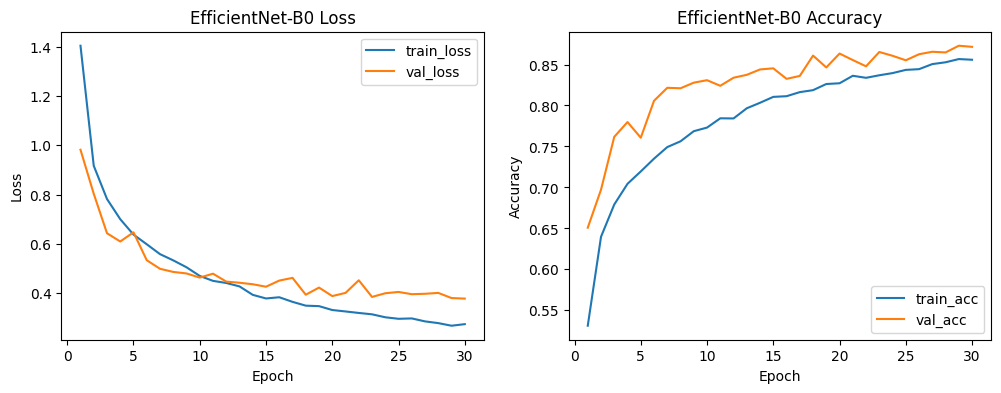

In [18]:
plot_history(history, model_name="EfficientNet-B0")


In [19]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)


In [20]:
evaluate_model(model)

                               precision    recall  f1-score   support

            Actinic keratoses       0.59      0.81      0.69        86
         Basal cell carcinoma       0.84      0.87      0.86       332
Benign keratosis-like lesions       0.69      0.79      0.74       262
                   Chickenpox       0.95      0.99      0.97       112
                       Cowpox       0.99      1.00      0.99        99
               Dermatofibroma       0.81      0.96      0.88        23
                         HFMD       0.98      1.00      0.99       241
                      Healthy       0.99      0.99      0.99       171
                      Measles       0.99      0.99      0.99        82
             Melanocytic nevi       0.94      0.83      0.88      1287
                     Melanoma       0.72      0.76      0.74       452
                    Monkeypox       1.00      0.98      0.99       426
      Squamous cell carcinoma       0.49      0.74      0.59        62
     

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 3674
Loaded checkpoint: EfficientNet-B0_best.pth
                               precision    recall  f1-score   support

            Actinic keratoses       0.57      0.83      0.68        88
         Basal cell carcinoma       0.86      0.87      0.87       333
Benign keratosis-like lesions       0.68      0.76      0.72       263
                   Chickenpox       0.96      0.97      0.96       113
                       Cowpox       1.00      1.00      1.00        99
               Dermatofibroma       0.79      0.76      0.78        25
                         HFMD       0.99      1.00      0.99       242
                      Healthy       1.00  

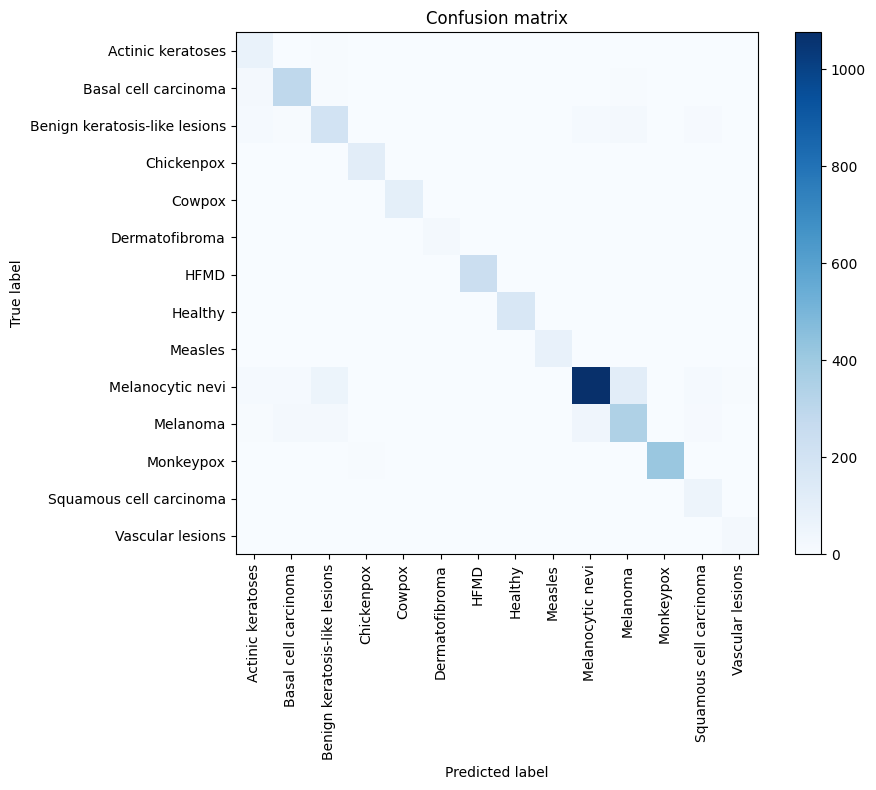

Saved test_predictions.csv


In [ ]:

%pip install pandas
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# path to test data 
test_dir = r"D:\archive\test"   

# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# load best checkpoint (if you saved it during training)
ckpt_path = "EfficientNet-B0_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print("Loaded checkpoint:", ckpt_path)
except Exception as e:
    print("Checkpoint load failed (using current model):", e)

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# optional: plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=90)
plt.yticks(tick_marks, test_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# optional: save per-image predictions (filenames, true, pred, prob)
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": filenames,
    "true": [test_dataset.classes[i] for i in y_true],
    "pred": [test_dataset.classes[i] for i in y_pred],
    "prob_top": [round(float(np.max(p)),4) for p in probs]
})
df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")